In [1]:
import qubic.toolchain as tc
import qubic.rpc_client as rc
import qubitconfig.qchip as qc
from distproc.hwconfig import FPGAConfig, load_channel_configs
import chipcalibration.config as cfg
import numpy as np
import matplotlib.pyplot as plt
import qubic.state_disc as sd
from chipcalibration import vna as vn
import qubic.job_manager as jm

## Load Configs and Define Circuit

define FPGA config; this has timing information for the scheduler. For now it is fine to use the following hardcoded config

In [2]:
fpga_config = FPGAConfig()
channel_configs = load_channel_configs('channel_config_hw.json')
qchip = qc.QChip('qubitcfg.json')
# qchip.cfg_dict

# Part 1: Testing loop back for both Q1 and Q3 on ADC1 (ADC_227_0)

### Define a circuit to generate pulses on Q3. (There's a typo in these plots. It should be ADC_227_0 and ADC_227_2, not ADC_237_0 and ADC_237_2. )

Q3.qdrv is connected to DAC_228_1. I also connceted Q3.rdlo -> ADC_227_0 (the ADC connceted in the gateware). To test different higher frequencies, I connceted Q3.qdrv from the DAC to the 1-4GHz balun and 4-5 GHz baluns to see the result. In the next section, I also connect Q1 to ADC_227_0, Q3 to ADC_227_2 and will show that ADC_227_2 doesnt work

In [3]:
def test_circuit(freq=350e6, qubit="Q3"):
    circuit = [
        # play a pi pulse on Q3
        {'name': 'pulse', 'phase': 0, 'freq': freq, 'amp': 0.90, 'twidth': 64e-9,
        'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
        'dest': f'{qubit}.qdrv'},
        
        {'name': 'delay', 't': 100.0715e-9},
        
        {'name': 'pulse', 'phase': 0, 'freq': freq, 'amp': 0.50, 'twidth': 64e-9,
        'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
        'dest': f'{qubit}.qdrv'},
        
        {'name': 'delay', 't': 100.0715e-9},
        
        {'name': 'pulse', 'phase': 0, 'freq': freq, 'amp': 0.90, 'twidth': 64e-9,
        'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
        'dest': f'{qubit}.qdrv'},
        
        {'name': 'delay', 't': 100.0715e-9}

    ]
    return circuit

In [4]:
# # plt.figure()

def plot_acq(acq_data, freq, qubit="Q3", balun="1-4GHz"):
    time = np.arange(0, acq_data['0'].shape[1] * 0.5e-9, 0.5e-9)[10:]
    first_adc_counts = np.average(acq_data['0'], axis=0)[10:]
    second_adc_counts = np.average(acq_data['1'], axis=0)[10:]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot for the first ADC
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('ADC Counts')
    ax1.plot(time, first_adc_counts, color='b')
    ax1.set_title('ADC_237_2')  # should be 227 not 237

    # Plot for the second ADC
    ax2.set_xlabel('Time (s)')# Submit the circuit to the server, and collect 1 shot. The runner will
    # run the currently loaded program (or a batch of circuits) and acquire
    # the results from acq buf or acc buf.
    ax2.set_ylabel('ADC Counts')
    ax2.plot(time, second_adc_counts, color='r')
    ax2.set_title('ADC_237_0')
    
    fig.suptitle(f"ACQ data on both ADCs for {freq / 1e9} GHz pulse for {qubit} on the {balun} balun")

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

### Now let's try to test with Q3 with the same configuration as Q3 balun and generate 3 GHz signals

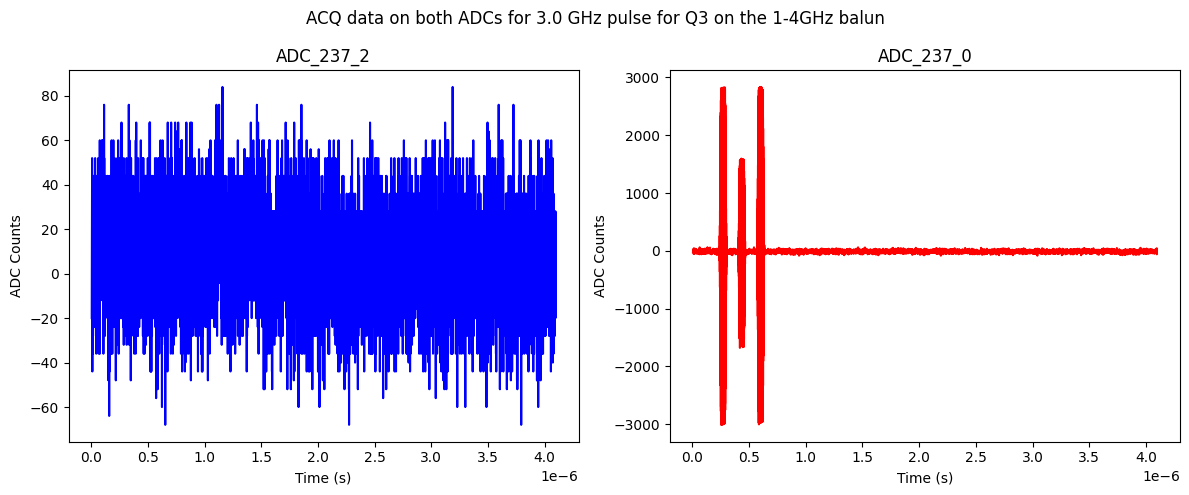

In [5]:
freq = 3000e6
circuit_q3 = test_circuit(freq=freq, qubit="Q3")
compiled_q3_prog = tc.run_compile_stage(circuit_q3, fpga_config, qchip)
raw_asm_q3 = tc.run_assemble_stage(compiled_q3_prog, channel_configs)
runner = rc.CircuitRunnerClient(ip='localhost', port=9095)

acq_data_q3 = runner.load_and_run_acq(
    raw_asm_q3, 
    n_total_shots=1,
    acq_chans={'0': 0,'1': 1},
    trig_delay=0e-9
)

# Submit the circuit to the server, and collect 1 shot. The runner will
# run the currently loaded program (or a batch of circuits) and acquire
# the results from acq buf or acc buf.

plot_acq(acq_data=acq_data_q3, qubit="Q3" freq=freq, balun="1-4GHz")

### Let's connect Q1 to a 1-4GHz balun and generate 3.5GHz signals

For Q1, the DAC is 228_3. I connect it to a 1-4GHz balun and loop back to ADC_237_0. I also plot the signals on both ADC for the sake of visualization

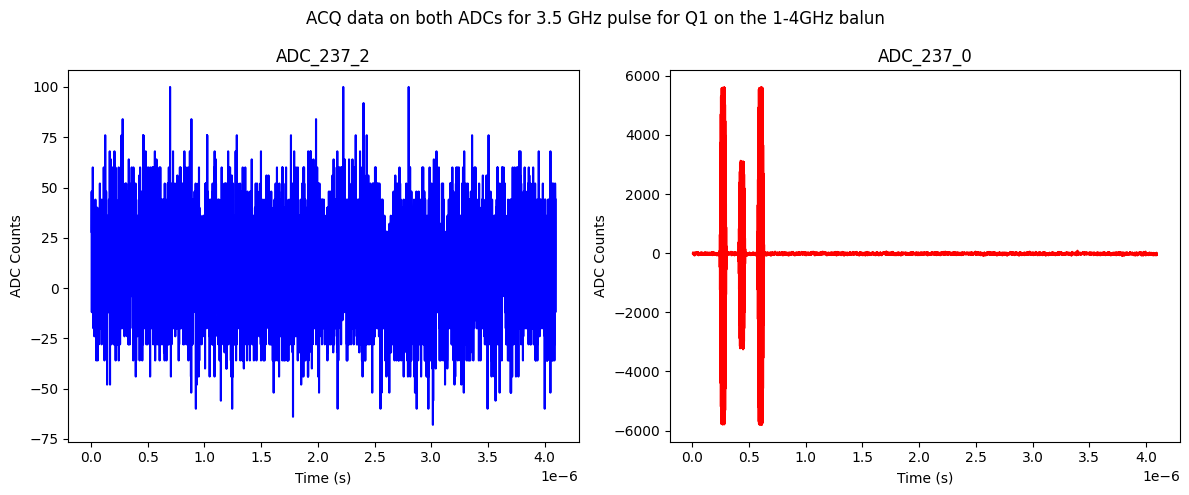

In [11]:
freq = 3500e6
circuit_q1 = test_circuit(freq=freq, qubit="Q1")
compiled_q1_prog = tc.run_compile_stage(circuit_q1, fpga_config, qchip)
compiled_q1_prog.program
raw_asm_q1 = tc.run_assemble_stage(compiled_q1_prog, channel_configs)
runner = rc.CircuitRunnerClient(ip='localhost', port=9095)

acq_data_q1 = runner.load_and_run_acq(
    raw_asm_q1, 
    n_total_shots=1,
    acq_chans={'0': 0,'1': 1},
    trig_delay=0e-9
)

plot_acq(acq_data=acq_data_q1, freq=freq, qubit="Q1", balun="1-4GHz")

Q1 is also working fine. Now let's connect Q1 (228_3 DAC) to a 5-6 GHz balun and generate a 5.5 GHz signals

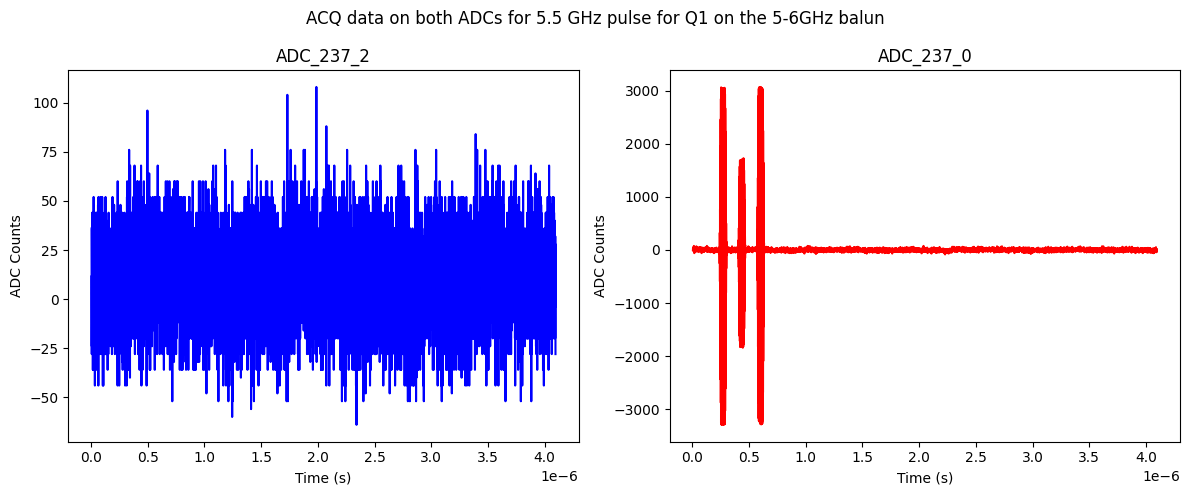

In [9]:
freq = 5500e6
circuit_q1 = test_circuit(freq=freq, qubit="Q1")
compiled_q1_prog = tc.run_compile_stage(circuit_q1, fpga_config, qchip)
compiled_q1_prog.program
raw_asm_q1 = tc.run_assemble_stage(compiled_q1_prog, channel_configs)
runner = rc.CircuitRunnerClient(ip='localhost', port=9095)

acq_data_q1 = runner.load_and_run_acq(
    raw_asm_q1, 
    n_total_shots=1,
    acq_chans={'0': 0,'1': 1},
    trig_delay=0e-9
)

plot_acq(acq_data=acq_data_q1, freq=freq, qubit="Q1", balun="5-6GHz")

# Part 2. Do the same exp for both Q1 and Q3, but do the loop back on the main ADC (ADC_227_2)

### Now let's try to test with Q1 (which we don't see wave in our last meeting) with the same configuration as Q3 balun and generate 3 GHz signals and measure it on the main ADC

let's define a new circuit, it should be two pulses with roughly equal amp

In [6]:
def new_test_circuit(freq=350e6, qubit="Q3"):
    circuit = [
        # play a pi pulse on Q3
        {'name': 'pulse', 'phase': 0, 'freq': freq, 'amp': 0.90, 'twidth': 64e-9,
        'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
        'dest': f'{qubit}.qdrv'},
        
        {'name': 'delay', 't': 100.0715e-9},
        
        {'name': 'pulse', 'phase': 0, 'freq': freq, 'amp': 0.80, 'twidth': 64e-9,
        'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
        'dest': f'{qubit}.qdrv'},
        
        {'name': 'delay', 't': 100.0715e-9}

    ]
    return circuit

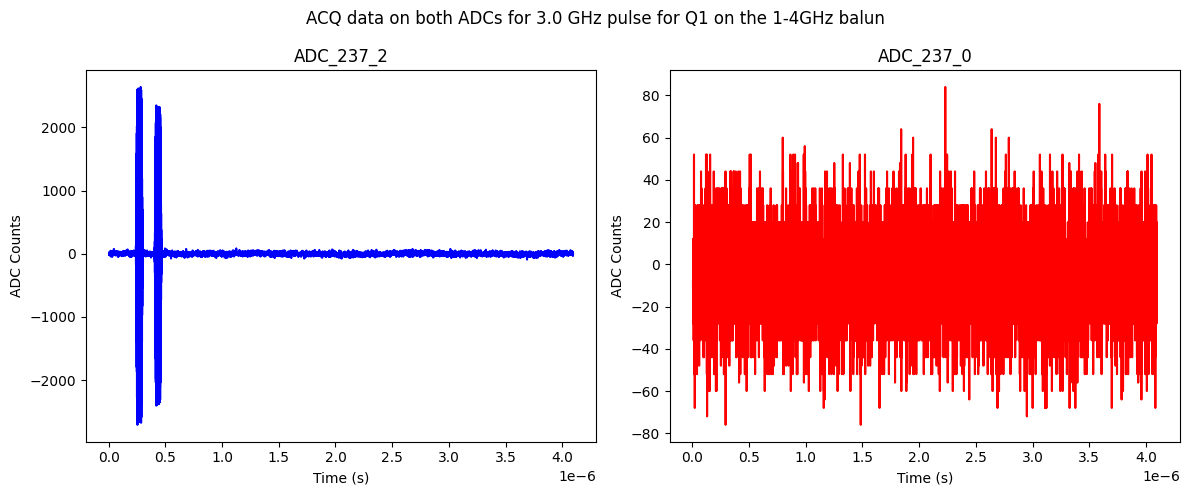

In [19]:
freq = 3000e6
circuit_q1 = new_test_circuit(freq=freq, qubit="Q1")
compiled_q1_prog = tc.run_compile_stage(circuit_q1, fpga_config, qchip)
compiled_q1_prog.program
raw_asm_q1 = tc.run_assemble_stage(compiled_q1_prog, channel_configs)
runner = rc.CircuitRunnerClient(ip='localhost', port=9095)

acq_data_q1 = runner.load_and_run_acq(
    raw_asm_q1, 
    n_total_shots=1,
    acq_chans={'0': 0,'1': 1},
    trig_delay=0e-9
)

# Submit the circuit to the server, and collect 1 shot. The runner will
# run the currently loaded program (or a batch of circuits) and acquire
# the results from acq buf or acc buf.

plot_acq(acq_data=acq_data_q1, freq=freq, qubit="Q1", balun="1-4GHz")

Let's test Q3 on a 4-5 GHz balun and loop back on ADC_227_2

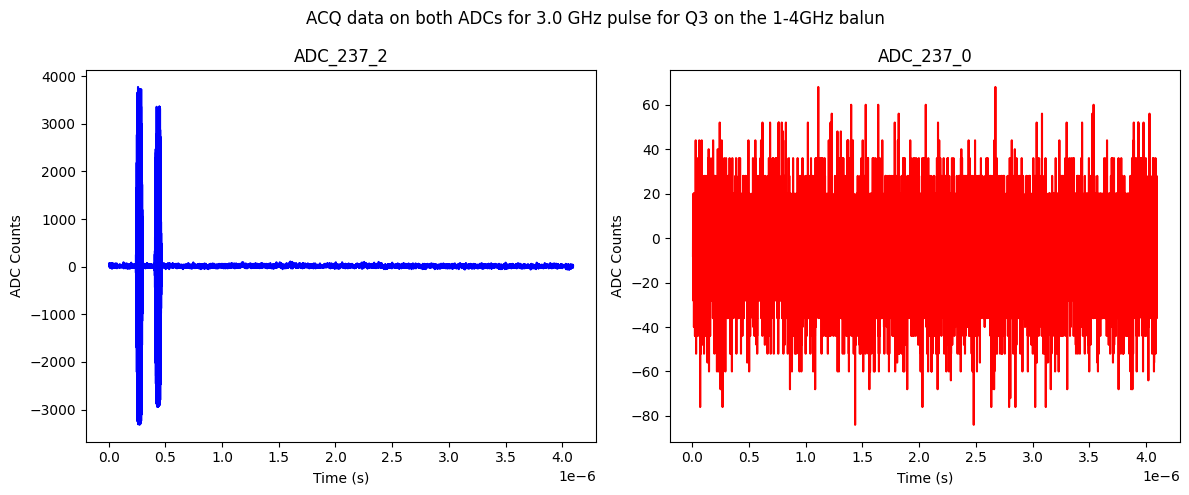

In [20]:
freq = 3000e6
circuit = new_test_circuit(freq=freq, qubit="Q3")
compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)
compiled_prog.program
raw_asm = tc.run_assemble_stage(compiled_prog, channel_configs)
runner = rc.CircuitRunnerClient(ip='localhost', port=9095)

acq_data = runner.load_and_run_acq(
    raw_asm, 
    n_total_shots=1,
    acq_chans={'0': 0,'1': 1},
    trig_delay=0e-9
)

# Submit the circuit to the server, and collect 1 shot. The runner will
# run the currently loaded program (or a batch of circuits) and acquire
# the results from acq buf or acc buf.

plot_acq(acq_data=acq_data, freq=freq, qubit="Q3", balun="1-4GHz")

### Now let's test Q7 with 1-4GHz on ADC_227_2

In [7]:
freq = 3000e6
circuit = new_test_circuit(freq=freq, qubit="Q7")
compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)
compiled_prog.program
raw_asm = tc.run_assemble_stage(compiled_prog, channel_configs)
runner = rc.CircuitRunnerClient(ip='localhost', port=9095)

acq_data = runner.load_and_run_acq(
    raw_asm, 
    n_total_shots=1,
    acq_chans={'0': 0,'1': 1},
    trig_delay=0e-9
)

# Submit the circuit to the server, and collect 1 shot. The runner will
# run the currently loaded program (or a batch of circuits) and acquire
# the results from acq buf or acc buf.

plot_acq(acq_data=acq_data, freq=freq, qubit="Q7", balun="1-4GHz")

Fault: <Fault 1: "<class 'KeyError'>:'qubit_command0'">

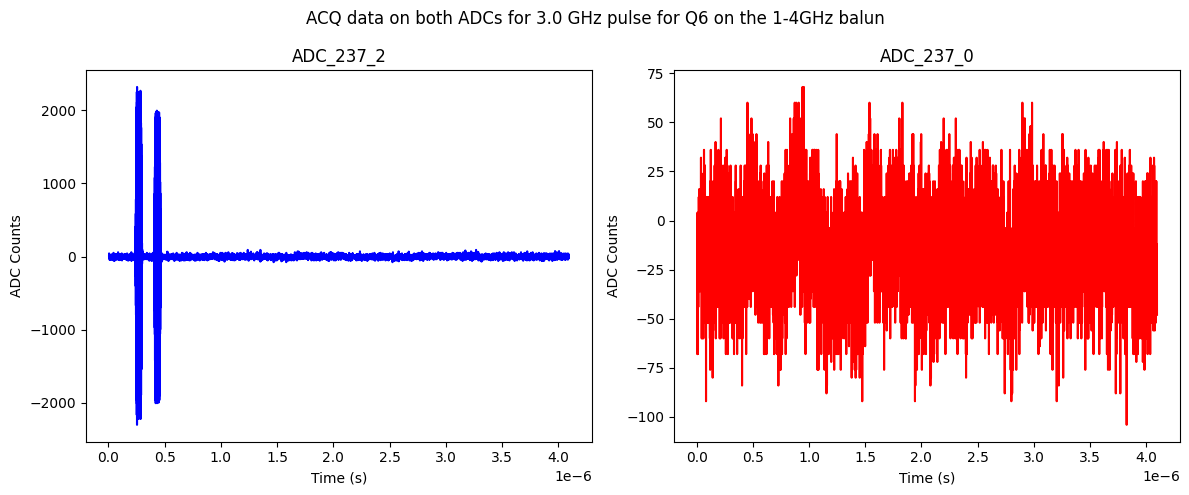

In [9]:
freq = 3000e6
circuit = new_test_circuit(freq=freq, qubit="Q6")
compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)
compiled_prog.program
raw_asm = tc.run_assemble_stage(compiled_prog, channel_configs)
runner = rc.CircuitRunnerClient(ip='localhost', port=9095)

acq_data = runner.load_and_run_acq(
    raw_asm, 
    n_total_shots=1,
    acq_chans={'0': 0,'1': 1},
    trig_delay=0e-9
)

# Submit the circuit to the server, and collect 1 shot. The runner will
# run the currently loaded program (or a batch of circuits) and acquire
# the results from acq buf or acc buf.

plot_acq(acq_data=acq_data, freq=freq, qubit="Q6", balun="1-4GHz")